In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
df_main = pd.read_csv(r"/content/data.csv", sep=';')

df = df_main[['federal_district', 'region_name', 'name_short', 'e1', 'e6', 'ege_budg']]
df = df.dropna(how='any')
df = df[(df['e1']>0) & (df['e6']>0) & (df['ege_budg']>0)]

name_short = df['name_short'].unique()
e1 = [round(df[df['name_short']==x].mean()['e1'], 2) for x in name_short]
e6 = [round(df[df['name_short']==x].mean()['e6'], 2) for x in name_short]
ege_budg = [round(df[df['name_short']==x].mean()['ege_budg'], 2) for x in name_short]

df = df.drop_duplicates(subset=['name_short'])
df['e1'] = e1
df['e6'] = e6
df['ege_budg'] = ege_budg

In [18]:
df = df.reset_index(drop=True)
df.head(5)

,federal_district,region_name,name_short,e1,e6,ege_budg
0,Южный федеральный округ,Республика Адыгея (Адыгея),ФГБОУ ВО «АГУ»,58.82,67.37,60.26
1,Сибирский федеральный округ,Алтайский край,ФГБОУ ВО «АлтГПУ»,62.08,77.72,64.23
2,Сибирский федеральный округ,Алтайский край,"ФГБОУ ВО ""Алтайский государственный технически...",59.23,81.44,61.37
3,Сибирский федеральный округ,Алтайский край,ФГБОУ ВО «Алтайский государственный университе...,64.45,78.20,69.50
4,Дальневосточный федеральный округ,Амурская область,ФГБОУ ВО «Амурский государственный университет...,56.79,75.84,58.86


Представлена база данных, содержащая информацию о множестве ВУЗов различных федеральных округов РФ.
Рассмотрим столбцы:
*   **e1** - Отношение числа студентов, обучающихся на бюджетной основе, к числу всех студентов ВУЗа (в процентах)
*   **e6** - Отношение числа выпускников, получивших работу в первый год после выпуска, к числу всех выпускников ВУЗа (в процентах)
*   **ege_budg** - Средний балл за ЕГЭ всех студентов ВУЗа

In [ ]:
df.describe()

,e1,e6,ege_budg
count,525.000000,525.000000,525.000000
mean,64.595410,80.328895,66.878781
std,7.960563,8.540086,9.417224
min,35.620000,43.670000,48.080000
25%,59.000000,76.160000,60.330000
50%,63.940000,81.330000,66.100000
75%,69.640000,85.740000,72.470000
max,97.980000,100.000000,100.000000


Видно, что средние значения всех стрёх столбцов достаточно близки к их соответствующим 50% квантилям. Этот факт подталкивает проверить выборку на нормальность.

In [ ]:
keys = ['e1', 'e6', 'ege_budg']

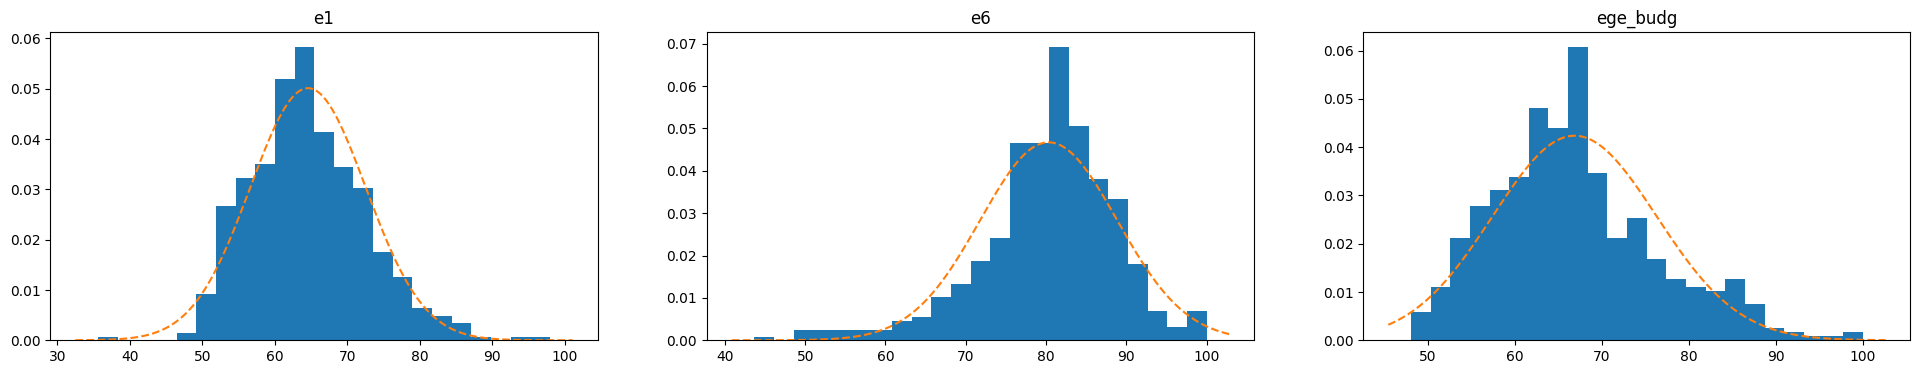

In [ ]:
fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(df[key], density=True, bins=23)
    
    loc = df[key].mean()
    scale = df[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)
plt.show()

Построим гистограммы интересующих нас столбцов, а также наложим поверх гистограм то, как бы выглядело нормальное распределение с параметрами, рассчитанными на основе выборок. Визуально все три параметра имеют нормальное распределение, но у **e6** и **ege_budg** один хвост имеет резкий обрыв. То есть имеет смысл изучать столбцы дальше и построить Q-Q кривую.

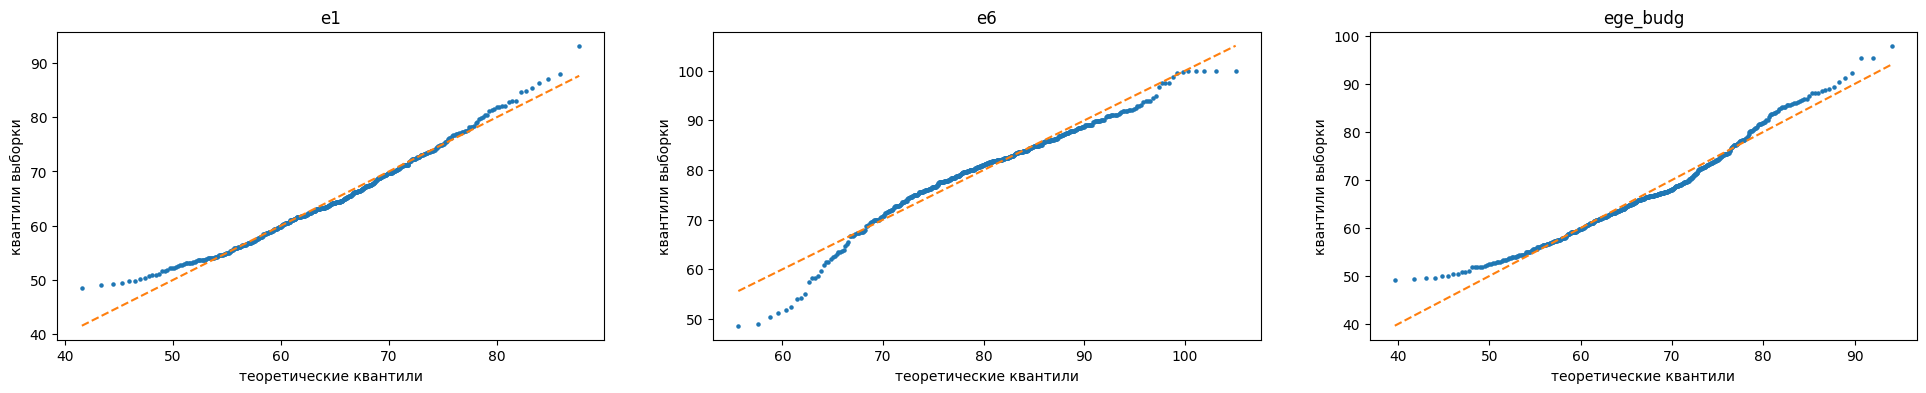

In [ ]:
fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5)
    ax.plot(x, x, color='C1', linestyle='dashed')
    
    ax.set_title(key)
    ax.set_xlabel('теоретические квантили')
    ax.set_ylabel('квантили выборки')
plt.show()

Видно, что столбцы **e6** и **ege_budg** имеют заметные отклонения от теоретических значений их квантилей, в то время как столбец **e1** лишь незначительно отклоняется. Окончательно определить, имеют ли выборки нормальное распределение, получится на основании расчетных значений.

In [ ]:
for key in keys:
    print(key)
    
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()

    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

e1
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6742857142857143
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9619047619047619
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9942857142857143

e6
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7390476190476191
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9352380952380952
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9828571428571429

ege_budg
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6838095238095238
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9561904761904761
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9923809523809524



По результатам такой оценки видно, что наиболее близким к нормальному распределению оказался столбец **ege_budg**, чьи значения отичаются от теоретических не более чем на 0.005. Столбец **e1** тоже близок к нормальному распределению, но его разница немного больше, чем у предыдущего. У столбца **e6** разница с теоретическим значением доходит до 0.05, но даже с такими показателями можно сказать, что все три выборки имеют нормальное распределение.

# Регрессии

Построим два графика распределения *(процент бюджетников к проценту трудоустроенных выпускников)* и *(средний балл за ЕГЭ к проценту бюджетников)*

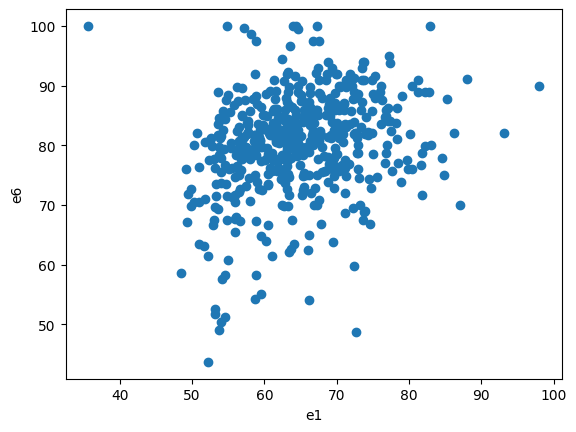

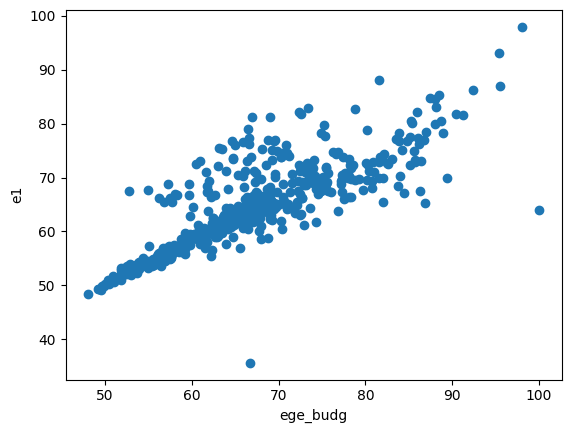

In [ ]:
plt.scatter(df['e1'], df['e6'])
plt.xlabel('e1')
plt.ylabel('e6')
plt.show()

plt.scatter(df['ege_budg'], df['e1'])
plt.xlabel('ege_budg')
plt.ylabel('e1')
plt.show()

Из первого графика трудно опеределить зависимость, зато из второго можно. Логично, что, чем больше средний балл за ЕГЭ среди студентов, тем больше в ВУЗе бюджетных мест и тем больше студентов на этих местах.

Расчитаем коффициенты регрессий для каждого отношения.

In [ ]:
for fi, se in [{'e1','e6'}, {'ege_budg','e1'}]:

    size = df.shape[0]

    ones = np.ones((size,1))
    x_pot = np.hstack((ones, df[fi].values.reshape(size,1)))

    XTX = x_pot.T.dot(x_pot)
    XTX_inv = np.linalg.inv(XTX)

    b = XTX_inv.dot(x_pot.T).dot(df[se])
    z = x_pot.dot(b)
    e = df[se] - z
    e1 = np.array(df[se])

    R = 1 - ((e - e.mean()) ** 2).sum() / ((e1 - e1.mean()) ** 2).sum()
    print(R)

0.06565637224562504
0.6591145166891158


Расчёты показывают, что для первого случая регрессия плохо описывает зависимость данных, а вот для второго эта зависимоть может прослеживаться. Результаты согласуются с предыдущими наблюдениями.

# Корреляция

Выше мы убедились, что выборки имеют нормальное распределение. Этот факт даёт нам право рассмотреть зависимость столбцов с помощью коэффициентов корреляции Пирсона.

In [ ]:
for fi, se in [{'e1','e6'}, {'ege_budg','e1'}]:
     print(df[[fi, se]].corr())

          e1        e6
e1  1.000000  0.256235
e6  0.256235  1.000000
                e1  ege_budg
e1        1.000000  0.811859
ege_budg  0.811859  1.000000


По результатам видно, что в первом случаи линейная корреляция наблюдается, но слабо, а вот во втором корреляция явно прослеживается. Но корреляция еще не является однозначным показателем зависисмости. Есть смысл проверить выборки на нелинейную зависисмость, воспользуемся ранговой корреляцией.

In [ ]:
for fi, se in [{'e1','e6'}, {'ege_budg','e1'}]:
     print(df[[fi, se]].corr(method='kendall'))

          e1        e6
e1  1.000000  0.186907
e6  0.186907  1.000000
                e1  ege_budg
e1        1.000000  0.682853
ege_budg  0.682853  1.000000


Проанализировав все результаты, приходим к выводу, что количесво трудоустроенных выпускников из ВУЗа практически не зависит от процентного содержания бюджетников этого же ВУЗа, а вот зависимость средних баллов за ЕГЭ и процент бюджетников всё-таки имеется.

# Интересно ответить еще на несколько вопросов по таблице

In [19]:
df_main = df_main[['federal_district', 'name_short', 'e5', 'total_income', 'square', 'pps', 'pk']]
df_main.tail(3)

,federal_district,name_short,e5,total_income,square,pps,pk
2561,Южный федеральный округ,ФГАОУ ВО «Севастопольский государственный унив...,162.82,1665959.5,117339,610,7191.85
2562,Центральный федеральный округ,"Московский политехнический университет, Москов...",161.80,3861039.2,194673,1063,13375.10
2563,Центральный федеральный округ,"Московский политехнический университет, Москов...",163.38,3371547.6,153417,1007,10669.15


*   **e5** - Отношение средней з/п преподавательского состава ВУЗа к средней з/п субъекта РФ.
*   **total_income** - Доходы вуза из всех источников (тыс. рублей).
*   **square** - Общая площадь учебно-лабораторных помещений (м2).
*   **pps** - Общая численность преподавательского состава ВУЗа.
*   **pk** - Общая численность студентов.

In [20]:
df_main.describe()

,e5,total_income,square,pps,pk
count,2564.000000,2.564000e+03,2564.000000,2564.000000,2564.000000
mean,126.754275,1.296238e+06,70193.908736,447.676287,4479.111466
std,63.298523,2.098639e+06,74677.740766,469.704762,4241.805360
min,0.000000,4.905648e+03,448.000000,0.000000,7.300000
25%,107.792500,3.751277e+05,28179.500000,169.750000,1521.462500
50%,145.370000,7.096716e+05,52809.500000,338.000000,3442.775000
75%,169.802500,1.274272e+06,91340.750000,550.000000,5830.850000
max,390.650000,3.258460e+07,988580.000000,5128.000000,33241.700000


Для удобства внесём все проделанные действия в отдельный метод. Будем считать выборку нормальной, если её распределение будет отличаться от теоретических не более чем на 0.05. Чтобы считать, что регрессия хоть как-то описывает зависисмость, коэффициент болжен быть больше 0.5. Такое же значение выберем для оценивания коэффициентов корреляции Пирсона и ранговой корреляции. 

In [12]:
def depend_analysis(fi, se):
    df_depend = df_main[['name_short', fi, se]]
    df_depend = df_depend.dropna(how='any')
    df_depend = df_depend[(df_depend[fi]>0) & (df_depend[se]>0)]
    arr = [round(df_depend[df_depend['name_short']==x].mean()[y], 2) for x in [fi, se] for y in [fi, se]]
    df_depend = df_depend.drop_duplicates(subset=[fi, se])
    for i in range(len(arr)):
        df_depend[i] = arr[i]

    cnt_depend = 0

    keys = [fi, se]
    fig, axes = plt.subplots(ncols=len(keys))
    fig.set_size_inches(8 * len(keys), 4)
    axes = axes.flatten()
    for key, ax in zip(keys, axes):
        samples = df_depend[key]
        loc = samples.mean()
        scale = samples.std()
        interval = np.linspace(0, 1, samples.shape[0])[1:-1]
        x = stats.norm.ppf(interval, loc=loc, scale=scale)
        y = np.quantile(samples, interval)
        ax.scatter(x, y, s=5)
        ax.plot(x, x, color='C1', linestyle='dashed')
        ax.set_title(key)
        ax.set_xlabel('теоретические квантили')
        ax.set_ylabel('квантили выборки')
    plt.show()

    is_norm = True
    no_cnt_sig = 0
    for key in [fi, se]:
        print(key)
        samples = df_depend[key]
        loc = samples.mean()
        scale = samples.std()
        for i in range(1, 4):
            true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
            sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
            print(f'{i} sigma(s)')
            print(f'\ttheoretical:\t{true_value}')
            print(f'\tsample:\t\t{sample_value}')
            if abs(sample_value - true_value) > 0.05:
                no_cnt_sig+=1
        if no_cnt_sig:
            print('Выборка',key,'распределена скорее не нормально')
            is_norm = False
        else:
            print('Выборка',key,'распределена скорее нормально')
        print()

    plt.scatter(df_depend[fi], df_depend[se])
    plt.title('Распределение выборок относительно друг друга')
    plt.xlabel(fi)
    plt.ylabel(se)
    plt.show()

    size = df_depend.shape[0]
    ones = np.ones((size,1))
    x_pot = np.hstack((ones, df_depend[fi].values.reshape(size,1)))
    XTX = x_pot.T.dot(x_pot)
    XTX_inv = np.linalg.inv(XTX)
    b = XTX_inv.dot(x_pot.T).dot(df_depend[se])
    z = x_pot.dot(b)
    e = df_depend[se] - z
    e1 = np.array(df_depend[se])
    R = 1 - ((e - e.mean()) ** 2).sum() / ((e1 - e1.mean()) ** 2).sum()
    print('R =', R)
    if abs(R)>0.5:
        print('Регрессия может описать зависисмость выборок')
        cnt_depend+=1
    else:
        print('Регрессия плохо описывает зависисмость выборок')
    print()

    if is_norm:
        corrP = df_depend[[fi, se]].corr().iloc[0, 1]
        print('corrP =', corrP)
        if abs(corrP)>0.5:
            print('По корреляции Пирсона линейная зависимость между выборками прослеживается')
            cnt_depend+=1
        else:
            print('По корреляции Пирсона линейная зависимость между выборками не прослеживается')
    else:
        print('Вычисление коэффициента корреляции Пирсона требует нормальное распределение')
    print()

    corrK = df_depend[[fi, se]].corr(method='kendall').iloc[0, 1]
    print('corrK =', corrK)
    if abs(corrK)>0.5:
        print('По ранговой корреляции зависисмость между выборками прослеживается')
        cnt_depend+=1
    else:
        print('По ранговой корреляции зависимость между выборками не прослеживается')
    print()

    if cnt_depend:
        print('Можно считать, что зависисмость между',fi,'и',se,'имеется')
    else:
        print('Зависисмости между',fi,'и',se,'скорее всего нет')

# Влияет ли общий доход ВУЗа на площадь лабораторных помещений?

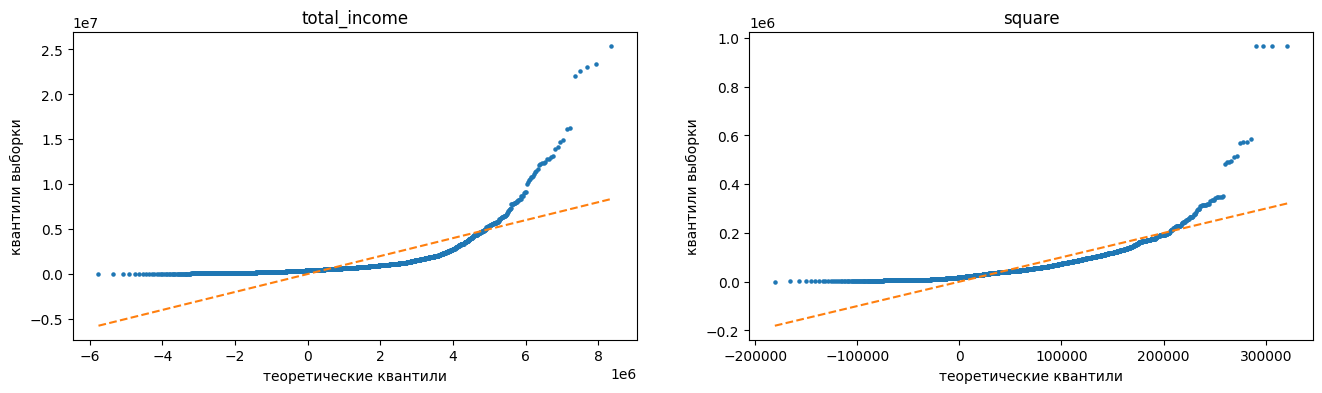

total_income
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.9235569422776911
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9629485179407177
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9797191887675507
Выборка total_income распределена скорее не нормально

square
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.9087363494539782
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.968798751950078
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.985179407176287
Выборка square распределена скорее не нормально



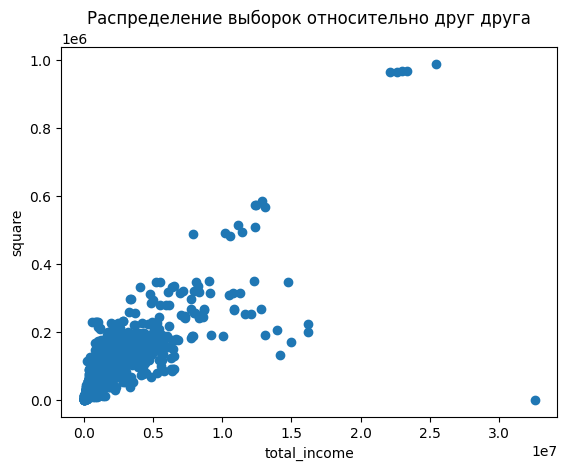

R = 0.6557766069782601
Регрессия может описать зависисмость выборок

Вычисление коэффициента корреляции Пирсона требует нормальное распределение

corrK = 0.6792972649939895
По ранговой корреляции зависисмость между выборками прослеживается

Можно считать, что зависисмость между total_income и square имеется


In [ ]:
depend_analysis('total_income', 'square')

Получается, что, если есть желание посвятить учебные годы науке, то стоит выбирать из ВУЗов с доходом выше среднего, т.е. больше 1.3 млрд. руб.

# Есть ли связь между общими численностями студентов и преподавателей?

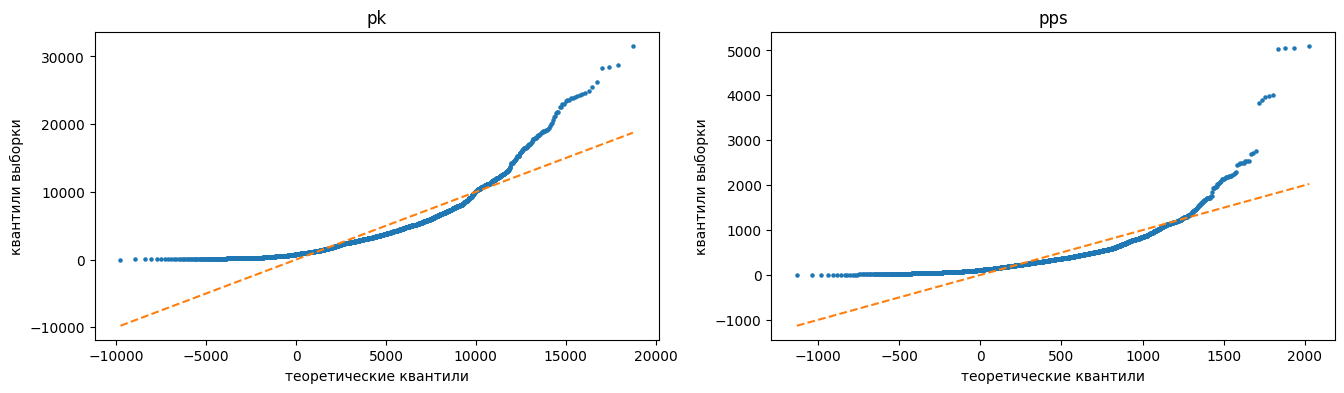

pk
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.8320968371729793
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9558766106989457
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.978524014057009
Выборка pk распределена скорее не нормально

pps
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.8969152674736431
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9656384224912143
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9816477938305349
Выборка pps распределена скорее не нормально



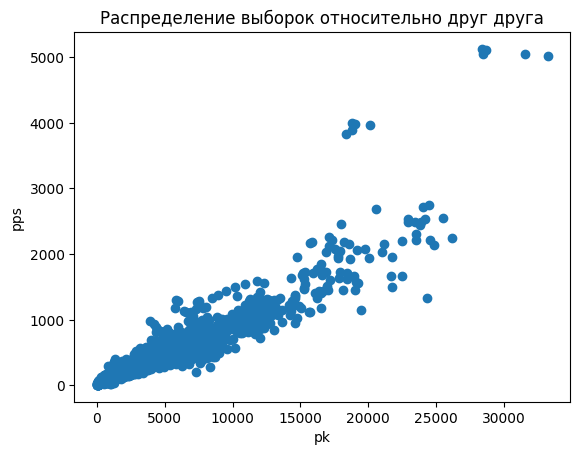

R = 0.8573652428004193
Регрессия может описать зависисмость выборок

Вычисление коэффициента корреляции Пирсона требует нормальное распределение

corrK = 0.835666437637596
По ранговой корреляции зависисмость между выборками прослеживается

Можно считать, что зависисмость между pk и pps имеется


In [13]:
depend_analysis('pk', 'pps')

Да, ну это и логично. Чем больше студентов обучаются в ВУЗе, тем больше и преподавателей, которые будут у них всех вести пары. Получается, что ВУЗы стараются не расширять лекционные помещения и не создавать огромные потоки студентов, а разделять их всех на меньшие, но ставить к каждому потоку отдельного преподавателя.

# А связь между численностью преподавателей и отношением их з/п к з/п по субъекту?

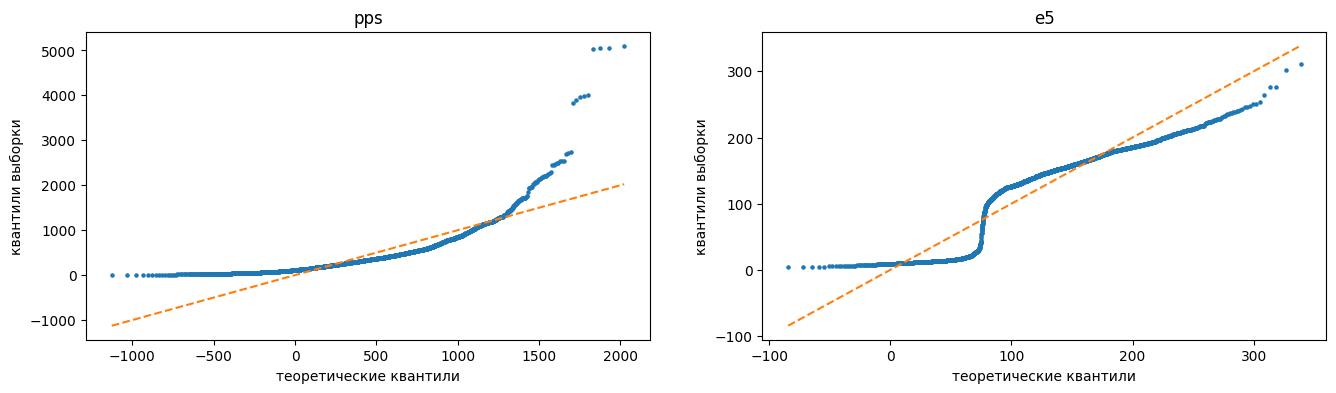

pps
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.8966731898238748
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9659491193737769
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9816046966731898
Выборка pps распределена скорее не нормально

e5
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7001956947162427
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9972602739726028
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9996086105675147
Выборка e5 распределена скорее не нормально



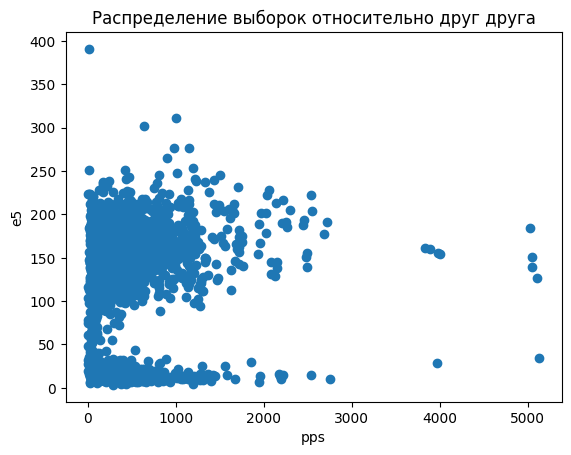

R = 0.002025999261113909
Регрессия плохо описывает зависисмость выборок

Вычисление коэффициента корреляции Пирсона требует нормальное распределение

corrK = 0.055440838852836065
По ранговой корреляции зависимость между выборками не прослеживается

Зависисмости между pps и e5 скорее всего нет


In [14]:
depend_analysis('pps', 'e5')

Видно, что связи тут нет. Хочется предположить, что з/п зависит от федерального окуга. Для проверки сравним среднее столбца **e5** для каждого округа.

<ipython-input-21-11bb3778a238>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = [df_main[df_main['federal_district']==x].mean()['e5'] for x in names]


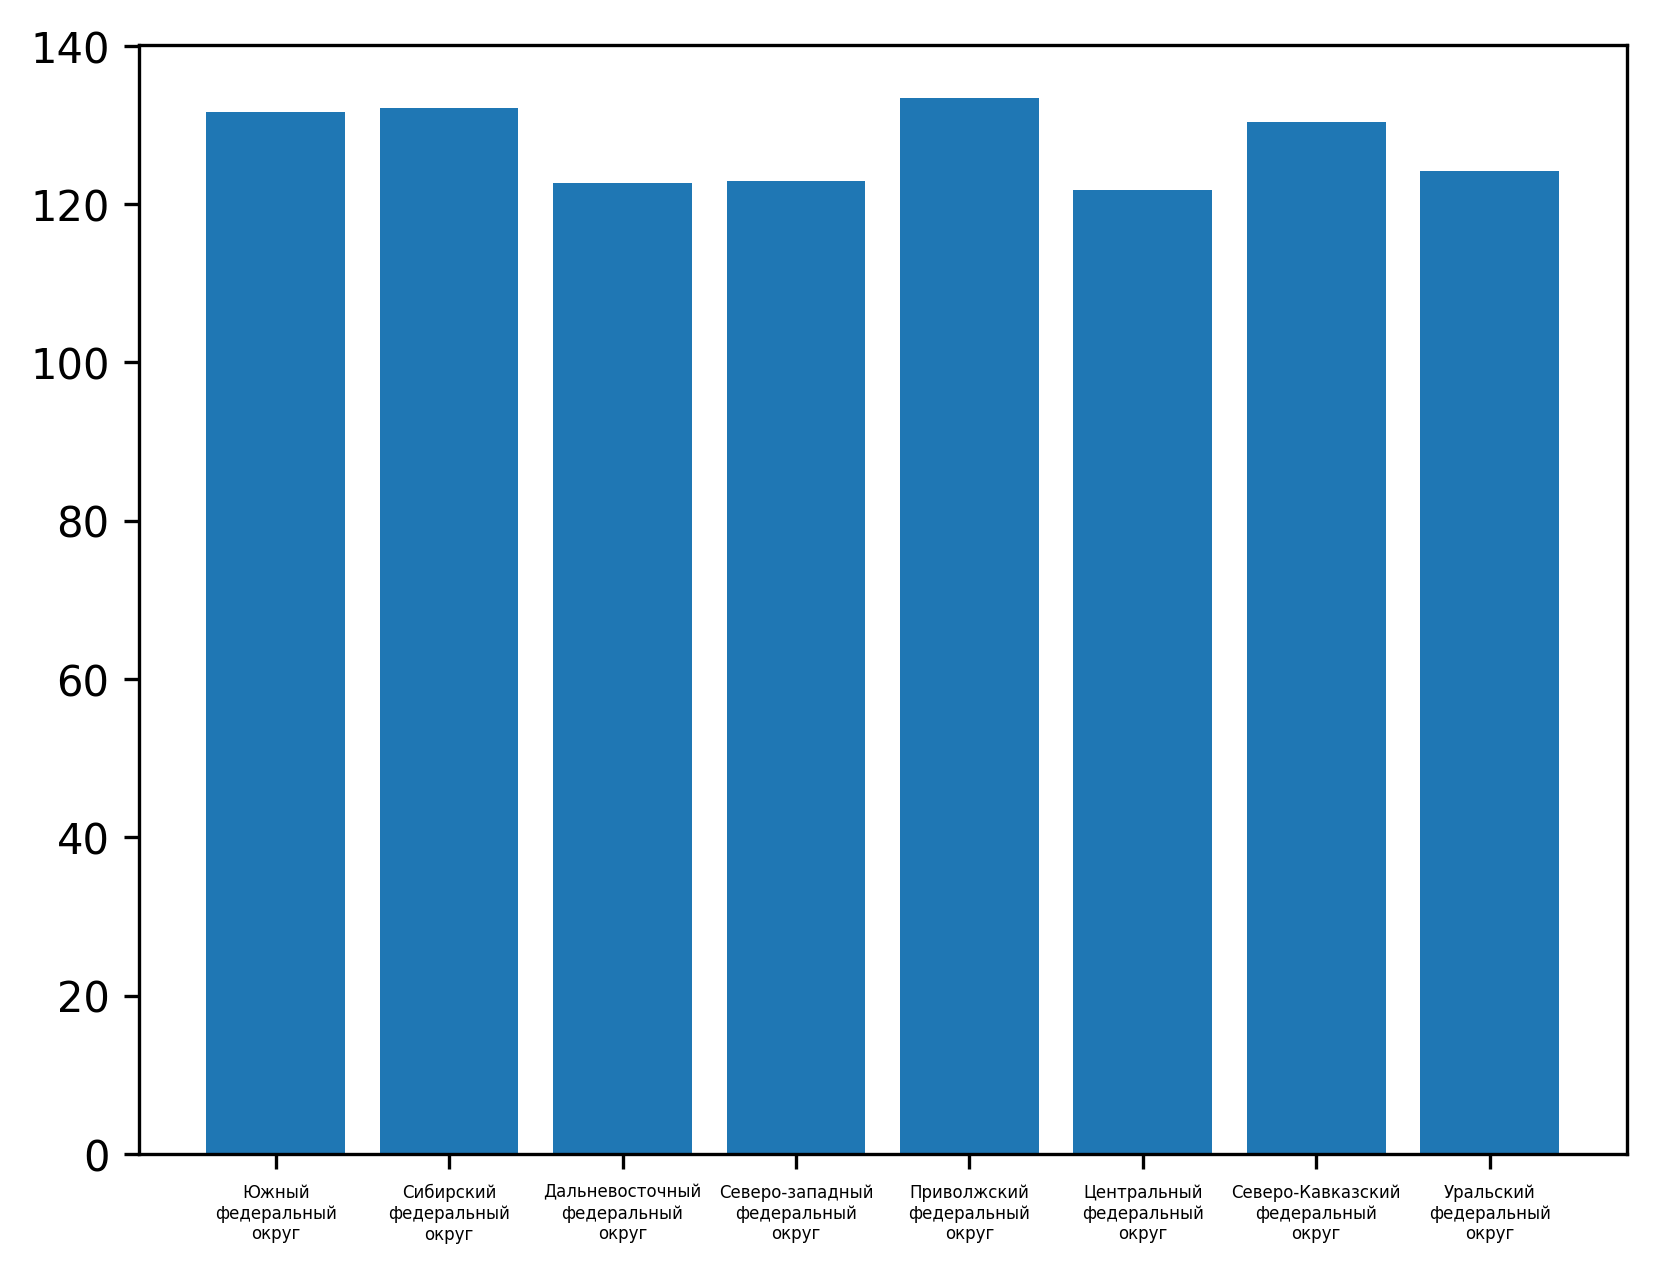

In [21]:
fig, ax = plt.subplots()
fig.set_dpi(300)
plt.xticks(rotation=0, fontsize=4)
names = df_main['federal_district'].unique()
means = [df_main[df_main['federal_district']==x].mean()['e5'] for x in names]
ax.bar([i.replace(' ','\n') for i in names], means)
plt.show()

Нет, не зависит, причем видно, что в более богатых округах отножение з/п меньше. Связано это с большими зарплатами населения таких округов.

# Вывод

1.   В ВУЗах с большими проходными баллами по ЕГЭ, как 
правило, больше бюджетных мест, но такие места еще не дают гарантию, что после ВУЗа студент найдёт себе работу.
2.   Будущим ученым в ВУЗ с доходом меньше 1.3 млрд. руб. документы лучше не подавать.
3.   ВУЗы предпочитаю пополнять ППС, чем платить за расширение аудиторий и строить новвые корпуса, но при этом при большим числе преподавателей их з/п не уменьшаются.